In [1]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import collections
from scipy.stats.stats import pearsonr
import pandas as pd
import os
from datetime import date

import seaborn as sns

In [2]:
# load of the data
DATASET_DIR = "dataset" + os.path.sep
df_tennis = pd.read_csv(DATASET_DIR + 'tennis_matches.csv', sep=',', index_col=0) 

#index_col=False say to not use the first column as ID
df_male = pd.read_csv(DATASET_DIR + 'male_players.csv', sep=',', index_col=False)
df_female = pd.read_csv(DATASET_DIR + 'female_players.csv', sep=',', index_col=False) 

# Data understanding

## Print some records of the datasets

In [ ]:
df_tennis.head()

In [ ]:
df_male.head()

In [ ]:
df_female.head()

## Missing values: Null

In [ ]:
#info about data that we have for male
df_male.info()

In [ ]:
#number of null in the columns
df_male.isnull().sum(axis = 0)

In [ ]:
df_male.isnull().sum(axis = 0).plot(kind='bar', ylabel="number of nulls")

So, the male dataframe has 2 columns: name and surname. It has 55208 entries and about 200 null values in total.

In [ ]:
#info about data that we have for female
df_female.info()

In [ ]:
#number of null in the columns
df_female.isnull().sum(axis = 0)

In [ ]:
df_female.isnull().sum(axis = 0).plot(kind='bar', ylabel="number of nulls")

So, the female dataframe has 2 columns: name and surname. It has 46172  entries and 1667 null values in the name, but the surname is never null.

In [ ]:
df_tennis.info()

In [ ]:
#we see if the attributes have some null values
df_tennis.isnull().any()

In [ ]:
#since all the attributes has missing values, we count them
df_tennis.isnull().sum(axis = 0)

We can notice that some attributes have very few null values, but other attributes has more than 50% of null values

In [ ]:
df_tennis.isnull().sum(axis = 0).hist(bins=8, grid=False)

## Duplicate data

In [ ]:
#we see if there are duplicates in the dataset male and female
df_male.duplicated(keep='first').sum()

In [ ]:
df_female.duplicated(keep='first').sum()

So, both the datasets of male and female has rows with same name and surname. These rows can be duplicates (so they correspond to the same person) or they can be homonyms. In this latter case we cannot distinguish the matches of one player by the ones of the other player.

In [ ]:
#we remove (only) the duplicated rows
df_male_no_dup = df_male.drop_duplicates()
df_female_no_dup = df_female.drop_duplicates()

In [ ]:
#see if a name can be both male and female and manage them
df_players = pd.concat([df_male_no_dup, df_female_no_dup])
df_players[df_players.duplicated(keep='first')==True]

In [ ]:
df_players.duplicated(keep='first').sum()

So, there are 74 names for both players male and female.

In [ ]:
df_players[df_players.duplicated(subset=['name', 'surname'], keep='first')==True]

In [ ]:
#check if there are duplicated rows in the dataset
df_tennis.duplicated(keep='first').sum()

## Noise, outliers and data quality (data visualization here)

|  Categorical  |   Ordinal   |      Numerical     | Ratio-Scaled |
|:-------------:|:-----------:|:------------------:|:------------:|
|   tournay_id  |  match_num  |      draw_size     |   winner_ht  |
|  tournay_name | winner_rank |       minutes      |  winner_age  |
|    surface    |             |     winner_ace     |              |
| tournay_level |             |      winner_df     |              |
|   winner_id   |             |     winner_svpt    |              |
|   winner_ioc  |             |    winner_1stln    |              |
|  winner_hand  |             |    winner_1stwon   |              |
|  winner_entry |             |    winner_2stwon   |              |
|    best_of    |             |       w_svgms      |              |
|               |             | winner_rank_points |              |
|               |             |      w_bdsaved     |              |
|               |             |      w_bdfaced     |              |

For each winner attribute there is the loser counterpart

### Invalid characters in names and surnames 

In [ ]:
#TO DO: Check that the names in female are for female and not male and viceversa

In [ ]:
#see if all the names and surnames are valid (only letters)
df_male[df_male['surname'].str.count("[a-zA-Z '.-]")!=df_male['surname'].str.len()]

In [ ]:
df_male[df_male['name'].str.count("[a-zA-Z ',.-]")!=df_male['name'].str.len()]

In [ ]:
df_check_name = df_male[~df_male['name'].isna()]
df_check_name[df_check_name['name'].str.contains(',')]

In [ ]:
df_female[df_female['surname'].str.count("[a-zA-Z '.-]")!=df_female['surname'].str.len()]

In [ ]:
df_female[df_female['name'].str.count("[a-zA-Z ',.-]")!=df_female['name'].str.len()]

In [ ]:
df_check_name = df_female[~df_female['name'].isna()]
df_check_name[df_check_name['name'].str.contains(',')]

So, in the male and female datasets we have some invalid names and surnames because of numbers, special characters of null values.

NOTE: "40071 	Jason "Jj",Belan 	NaN" is an error because Belan is the surname but pandas has not divided the name by the surname (male). Correction in the data preparation

### Analysis of tennis dataset

In [ ]:
df_tennis.dtypes.value_counts()

In [ ]:
#Values in the columns with type object
for column in df_tennis.select_dtypes(include=['object']).columns:
    print("Distinct Values in "+str(column)+": \n", df_tennis[column].unique(), "\n")

#### tourney_id

In [ ]:
#check that for non null values, the first 4 char are the year
#count rows whose firts 4 char are not numbers
df_tennis[df_tennis['tourney_id'].str[:4].str.isnumeric()==False].shape[0] 

In [ ]:
#chech if some years are in the future (so are invalid)(ignore nulls)
df_tennis[pd.to_numeric(df_tennis['tourney_id'].str[:4]).fillna(0).astype('int') > date.today().year].shape[0] 

In [ ]:
#chech if there are invalid years because to much in the past (ignore nulls)
df_tennis[pd.to_numeric(df_tennis['tourney_id'].str[:4]).fillna(date.today().year).astype('int') < 1874 ].shape[0] 

So, the first 4 numbers in the tourney_id are always valid when the tourney_id id not null

In [ ]:
#chech that for each tourney there is more than one match (every id appears more than once)
df_tennis[df_tennis['tourney_id'].duplicated(keep=False)==False].shape[0] 

So, every torney_id appears more than once

In [ ]:
#check how many distinct tourney are present
df_tennis["tourney_id"].value_counts().count()

#### tourney_name

In [ ]:
#chech that for the same tourney_id we have always the same name
len(df_tennis.groupby(['tourney_id','tourney_name']).size())-len(df_tennis.groupby(['tourney_id']).size())

In [ ]:
len(df_tennis.groupby(['tourney_name','tourney_id']).size())-len(df_tennis.groupby(['tourney_name']).size())

For a certain tourney_id we may have more tourney_names, so we should manage these names for example to remove errors from some rows. For a tourney_name we can have more tourney_ids.

In [ ]:
#len(df_tennis["tourney_name"].unique()) #consider also the nan
df_tennis["tourney_name"].value_counts().count() #do not consider also the nan

#### tourney_level

In [ ]:
#TO DO: check that tourney level for male are associated to tourney with male players (same for female).
#explain also the meanings of the levels

In [ ]:
levels_man = ['G', 'M', 'A', 'C', 'S', 'F', 'D']

In [ ]:
levels_woman = levels_man + ['P', 'PM', 'I', 'T1']
levels_woman_man = ['E','J','T'] #not present in the dataset yet (documentation)
all_levels = levels_man + levels_woman + levels_woman_man

In [ ]:
#check what are other codes that can appear (for women)
df_other_levels = df_tennis[~df_tennis['tourney_level'].isin(all_levels)]
#get codes about the prize money
df_other_levels[df_other_levels['tourney_level'].str.isnumeric()==True]['tourney_level'].unique()

These are the numeric codes that appear in the dataset

In [ ]:
#get the other codes not cited in the document and that are not prize
df_other_levels[df_other_levels['tourney_level'].str.isnumeric()==False]['tourney_level'].unique()

We have 2 more codes respect the one expressely indicated by the documentation

In [ ]:
#check if there are at least one row for each cited code
list(set(all_levels) - set(df_tennis[df_tennis['tourney_level'].str.isnumeric()==False]['tourney_level'].unique()))

For these codes there are no rows in the dataset

In [ ]:
#get the occurrenes of each level
df_tennis["tourney_level"].value_counts()

In [ ]:
df_tennis["tourney_level"].value_counts().plot(kind='bar', ylabel="number of nulls")

#### winner_name and loser_name

In [ ]:
#check that names are valid
df_tennis[df_tennis['winner_name'].str.count("[a-zA-Z ',.-]")!=df_tennis['winner_name'].str.len()]['winner_name']

In [ ]:
df_tennis[df_tennis['loser_name'].str.count("[a-zA-Z ',.-]")!=df_tennis['loser_name'].str.len()]['loser_name']

There are invalid characters in the names of some winners and some losers

#### winner_id and loser_id

In [ ]:
#TO DO: SEE ID A WINER ID IS ASSOCIATED TO MORE WINNER NAMES OR ALWAYS TO THE SAME ONE. SAME FOR LOSER
#TO DO: CONTROLLARE CHE GLI ID PER LO STESSO GIOCATORE SIA WINNER E LOSER SONO UGUALI
#to do: vedere se gli id vincitore-perdente è uguale

In [ ]:
#check if there are records in whitch the winner_id e loser_id corrispondono
def find_match_sameWL():
    df_sameWL = df_tennis[df_tennis['winner_id'] == df_tennis['loser_id']][['tourney_id','match_num','winner_id', 'loser_id', 'winner_name', 'loser_name']]
    print(df_sameWL.shape[0])
    return df_sameWL
    
find_match_sameWL()

There are five records in whitch winner and loser are the same. 

In [ ]:
#check for duplicate id on winner name
w_ids = dict.fromkeys(df_tennis['winner_id'].unique().tolist(), None)
duplicate_w_id = {}
for w_id in w_ids.keys():
    w_names = df_tennis[df_tennis['winner_id'] == w_id]['winner_name'].unique().tolist()
    if len(w_names) > 1:
        tourney1 = set(df_tennis.loc[(df_tennis['winner_id'] == w_id) &
                                (df_tennis['winner_name'] == w_names[0]) ]['tourney_id'].unique())
        tourney2 = set(df_tennis.loc[(df_tennis['winner_id'] == w_id) &
                                 (df_tennis['winner_name'] == w_names[1])]['tourney_id'].unique())
        if len(tourney1.intersection(tourney2)) > 0:
            duplicate_w_id[w_id] = w_names
duplicate_w_id

In [ ]:
#check for duplicate id on loser name
l_ids = dict.fromkeys(df_tennis['loser_id'].unique().tolist(), None)
duplicate_l_id = {}
for l_id in l_ids.keys():
    l_names = df_tennis[df_tennis['loser_id'] == w_id]['loser_name'].unique().tolist()
    if len(l_names) > 1:
        tourney1 = set(df_tennis.loc[(df_tennis['loser_id'] == w_id) &
                                (df_tennis['loser_name'] == l_names[0]) ]['tourney_id'].unique())
        tourney2 = set(df_tennis.loc[(df_tennis['loser_id'] == w_id) &
                                 (df_tennis['loser_name'] == l_names[1])]['tourney_id'].unique())
        if len(tourney1.intersection(tourney2)):
            duplicate_l_id[l_id] = l_names
duplicate_l_id

In [ ]:
df_tennis['winner_id'].value_counts()

In [ ]:
df_tennis['loser_id'].value_counts()

#### winner_hand and loser_hand

In [ ]:
#check that there are not indicated hand that are invalid (ignore nulls)
hand = ['R','L','U']
df_tennis[~df_tennis['winner_hand'].fillna('U').str.upper().isin(hand)].shape[0]

In [ ]:
df_tennis[~df_tennis['loser_hand'].fillna('U').str.upper().isin(hand)].shape[0]

In [7]:
#check based on id and name
errors = []
players_ids = df_tennis['winner_id'].dropna().unique().tolist() + df_tennis['loser_id'].dropna().unique().tolist()

for player_id in players_ids:
    name_players = df_tennis[df_tennis['winner_id']==player_id]['winner_name'].dropna().unique().tolist()
    name_players = name_players + df_tennis[df_tennis['loser_id']==player_id]['loser_name'].dropna().unique().tolist()
    name_players = list(dict.fromkeys(name_players))
    for name in name_players:
        hands = df_tennis[df_tennis['winner_name']==name]['winner_hand'].dropna().unique().tolist()
        hands = hands + df_tennis[df_tennis['loser_name']==name]['loser_hand'].dropna().unique().tolist()
        hands = list(dict.fromkeys(hands))
        if len(hands)==3:
            errors.append(name)
        elif len(hands)==2 and 'U' not in hands:
            errors.append(name)
            
print(errors) #result:[]

[]


There are not invalid entries for the hand of winner or loser. Furthermore thare are not different hands for the same player

In [ ]:
index = df_tennis[~df_tennis['winner_hand'].isna()]['winner_hand'].unique()
pd.DataFrame({'winner': df_tennis['winner_hand'].value_counts(), 'loser': df_tennis['loser_hand'].value_counts()}, index=index).plot.bar(color=["#66ff66","#6666ff"])

#### winner_ioc and loser_ioc, International Olympic Code validity check

In [ ]:
df_countrycode = pd.read_csv(DATASET_DIR + 'country-codes_csv.csv', sep=',', index_col=False) 

##### Wrong codes winner_ioc

In [ ]:
w_check_cc = pd.Series(~df_tennis.winner_ioc.isin(df_countrycode.IOC).values, df_tennis.winner_ioc.values)
w_check = w_check_cc[w_check_cc].index
w_check.value_counts()

##### Wrong codes loser_ioc

In [ ]:
l_check_cc = pd.Series(~df_tennis.loser_ioc.isin(df_countrycode.IOC).values, df_tennis.loser_ioc.values)
l_check = l_check_cc[l_check_cc].index
l_check.value_counts()

We can verify that the list of IOC codes that is incorrect is not in ISO format by mistake.

In [ ]:
i = w_check.unique()
type(i)
for c in i:
    exist =  df_countrycode["ISO3166-1-Alpha-3"].str.contains('MNE').any()
    print(c + " " + str(exist))

In [ ]:
i = l_check.unique()
type(i)
for c in i:
    exist =  df_countrycode["ISO3166-1-Alpha-3"].str.contains('MNE').any()
    print(c + " " + str(exist))

**best_of**

In [ ]:
#check if there are different values form 3 or 5
df_tennis['best_of'].value_counts(dropna = False)

There are not different values from 3 and 5, a part for some null values.

In [ ]:
df_tennis['best_of'].value_counts().plot(kind='bar')

#### score
https://www.wikihow.it/Tenere-il-Punteggio-a-Tennis

If the **match** is at best of 3 then a player, to win, must win 2 sets. If instead it's at best of 5 the playes must win 3 sets.

Every sets is composed by **games**. The winner is the player that wins 6 games with at least 2 games od advantage (for example 6-4, 6-3, ..., but not 6-5).

In the case of 6-5 the first player wins the set is win the following game (7-5).

In case pf 6-6 the **Tie-Break** is played. The Tie-Break is won by the player that is the first to do 7 points with an advantage of 2 (so, for example, 7-5, 7-4, ...). If both the players do 6 points then wins the first that have 2 points of advantage on the adversary (for example 8-6, 9-7, 10-8, ...)

In [ ]:
#check that all the scores of the match are valid. (we do not consider nulls)
df_tennis_score = df_tennis[~df_tennis['score'].isna()]

Walkover ("WO" or "w/o")- Unopposed victory. A walkover is awarded when the opponent fails to start the match for any reason, such as injury.

Retirement ("ret") - Player's withdrawal during a match, causing the player to forfeit the tournament. Usually this happens due to injury

Default :def - Disqualification of a player in a match by the chair umpire after the player has received four code violation warnings, generally for their conduct on court. A default can occur with less than four code violations warnings if the code violation is judged severe enough to warrant it. A double default occurs when both players are disqualified. Defaults also occur when a player misses a match with no valid excuse. Defaults are considered losses.

Bye :bye - Automatic advancement of a player to the next round of a tournament without facing an opponent. Byes are often awarded in the first round to the top-seeded players in a tournament

In [ ]:
def Retirement(s):
    if s.lower() in "retirement." or s.lower()=="ret.":
        return True
    else:
        return False
    
def Walkover(s):
    if s.lower()=="w/o" or s.lower()=="wo" or s.lower() in "walkover":
        return True
    else:
        return False
    
def Default(s):
    if s.lower() in "default." or s.lower()=="def.":
        return True
    else:
        return False
    
def Bye(s):
    if s.lower() in "bye.":
        return True
    else:
        return False

Reasons for games not played

In [ ]:
#error because less of 2 games without valid reasons
count_less_2 = 0
#error because we have too many games in a match
too_many = 0

#number of walkover
walkover = 0
#errors using RET instead of WO
wrong_walkover = 0
#number of defaults
default = 0
#number of byes
bye = 0

for match in df_tennis[~df_tennis['score'].isna()]['score']:
    sets = match.split( )
    if len(sets)==1 and Walkover(sets[0]):
        walkover+=1
        continue
    if len(sets)==1 and Retirement(sets[0]):
        wrong_walkover+=1
        continue
    if len(sets)==1 and Default(sets[0]):
        default+=1
        continue
    if len(sets)==1 and Bye(sets[0]):
        bye+=1
        continue
    if len(sets)<2:
        count_less_2+=1
        continue
    #maximum number of sets for best of 5 is 6: 5 games + RET or DEF
    if len(sets)>6:
        too_many+=1
        continue

In [ ]:
print('walkover:', walkover)
print('wrong_walkover:', wrong_walkover)
print('default:', default)
print('bye:', bye)
print('errors: less than 2 games:', count_less_2)
print('errors: too many games:', too_many)

In [ ]:
index = ["Walkover", "Default", "Bye", "Ret as wolkover", "Erorrs"]
values = [walkover, default, bye, wrong_walkover, count_less_2+too_many]
plt.bar(index,values, width=0.5, color="#66ff66")

So, these games are not played. There is a wrong use of retirement because a retirement before the game is called walkover. This is used in a wrong way 8 times.

In [ ]:
def validity_match(games, best_of):
    if len(games)<math.trunc(best_of/2)+1 or len(games)>best_of+1:
        if not Retirement(games[len(games)-1]) and not Default(games[len(games)-1]):
            return False
    
    first_player = 0
    second_player = 0
    
    if Retirement(games[len(games)-1]) or Default(games[len(games)-1]):
        #analysis of set with a ret or def
        game = games[len(games)-2].replace("[", "").replace("]", "")
        points = game.split("-")
        
        if "(" in game or ")" in game:
            points = game[0:(game.index("("))].split("-")
            if "6" not in points or ("7" not in points and points.count('6')!=2):
                return False
        else:
            x = int(points[0])
            y = int(points[1])

            if not ((max(x,y) <= 6 and min(x,y)<=6) or (max(x,y) == 7 and min(x,y)==5)):
                return False
        
        complete_sets = len(games)-2
    else:
        complete_sets = len(games)
    
    i = 0
    #analysis of complete sets
    while i < complete_sets:
        
            game = games[i].replace("[", "").replace("]", "")
            
            if "(" in game or ")" in game:
                #tie-break
                points = game[0:(game.index("("))].split("-")
                if "6" not in points or "7" not in points:
                    return False
                else:
                    if points[0] == "6":
                        second_player+=1
                    else:
                        first_player+=1
                    i+=1
            else:
                #no tie-break
                game = games[i].replace("[", "").replace("]", "")
                points = game.split("-")
    
                x = int(points[0])
                y = int(points[1])
                
                if max(x,y) == 7 and min(x,y)!=5:
                    return False
                elif max(x,y)!= 6 and (max(x,y) != 7 or min(x,y)!=5):
                    return False
                elif max(x,y)==6 and (min(x,y)>4 or min(x,y)<0):
                    return False
                else:
                    #valid case
                    if x == min(x,y):
                        second_player+=1
                    else:
                        first_player+=1
                    i+=1
                
            if (first_player==math.trunc(best_of/2)+1 or second_player==math.trunc(best_of/2)+1) and \
                (second_player + first_player)!=len(games):
                return False
            
    return True
    

In [ ]:
#best of 5: 3,4 o 5 games, best of 3: 2 or 3 games (with points)
best_5 = 0
best_3 = 0

valid_change_best_of = 0
invalid_matches = 0


#check of the best of 3
for match in df_tennis_score[df_tennis_score['best_of']==3]['score']:
    sets = match.split( )
    #maximum number of sets for best of 3 is 4: 3 games + RET or DEF
    if len(sets)>4 or (len(sets)==4 and not Retirement(sets[3]) and not Default(sets[3])):
        best_5+=1
        #print(sets)
        if validity_match(sets, 5) == True:
            valid_change_best_of +=1
        else:
            invalid_matches+=1
    elif len(sets)>=2:
        if validity_match(sets, 3) == False:
            invalid_matches+=1
        
        
#check of the best of 5
for match in df_tennis_score[df_tennis_score['best_of']==5]['score']:
    sets = match.split( )
    if len(sets)==2 and not Retirement(sets[1]) and not Default(sets[1]):
        best_3+=1
        if validity_match(sets, 3) == True:
            valid_change_best_of +=1
        else:
            invalid_matches+=1
    elif len(sets)>=2:
         if validity_match(sets, 5) == False:
            invalid_matches+=1

    

In [ ]:
print('errors: best of 5 classyfied as best of 3:', best_5)
print('errors: best of 3 classyfied as best of 5:', best_3)
print('valid change of best of', valid_change_best_of)
print('Invalid matches', invalid_matches)

In [ ]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)

plt.subplot2grid(fig_dims, (0, 0))
plt.bar(["best 5 as 3", "best 3 as 5"], [best_5, best_3], width=0.5, color="#66ff66")

plt.subplot2grid(fig_dims, (0, 1))
plt.bar(["Total changes best_of", "Valid changes best_of"], [best_5+best_3, valid_change_best_of], width=0.5, color="#6666ff")

plt.subplot2grid(fig_dims, (0, 2))
plt.bar(["invalid for wrong best_of", "invalid matches"], [valid_change_best_of, invalid_matches], width=0.5, color="#ff6666")

There are some invalid points about some games of some matches. There are some matches classifyed as best of 3 but have more than 3 games and they can be classified as best of 5. The same for the best of 5. These are 45. There are some matches that are not valid (5217) because the results of the games are inpossible results because the rules of the tennis. 

We can see in the first bar chart that most of the error of classification are about matches best of 5 classified as best of 3. In the second chart we can notice that we can correct this classification for most of these matches. 

In the 3rd chart we can see that the error we have notice in the match because of a wrong classification are a very small part of the total errors. So, the most of the errors in the scores are not because the classification is wrong, but because the saved results are invalid.

#### match_num

In [ ]:
df_tennis_matchgroups = df_tennis.drop_duplicates().groupby(['tourney_id', 'match_num']).size().reset_index(name='size')
print(df_tennis_matchgroups[df_tennis_matchgroups['size']>2])
#number of match with more than one winner
df_tennis_matchgroups[df_tennis_matchgroups['size']>2].shape[0]

In [ ]:
prova = df_tennis[df_tennis['tourney_id']=='2016-520']
prova[prova['match_num']==100][['tourney_id', 'tourney_name', 'match_num', 'winner_name', 'loser_name']]

#### draw_size

In [ ]:
#count the row with an invalid number (negative or less than 2)
df_tennis[df_tennis['draw_size'] < 2].shape[0]

All the numbers are valid (we consider only the numbers and not the nulls)

**tourney_date**

In [ ]:
#the date are in float so they need to be converted in date object 
df_tennis['tourney_date'].isnull().sum()

In [ ]:
#check if there are present data greater then today
import datetime
df_tennis['tourney_date'] = pd.to_datetime(df_tennis['tourney_date'], format='%Y%m%d')
invalid_data = 0
today = pd.to_datetime(datetime.date.today())
for date in df_tennis['tourney_date']:
    if date > today:
        invalid_data +=1
print(invalid_data)

There aren't invalid dates

#### winner_ht and loser_ht

In [ ]:
df_tennis['winner_ht'].max()

In [ ]:
df_tennis['winner_ht'].min()

In [ ]:
# print all possibile winner ht in an asc sort order
df_tennis['winner_ht'].value_counts().sort_index()

In [ ]:
df_tennis['winner_ht'].value_counts().sort_index().plot.bar(
    figsize=(10, 4), 
    title="winner_ht distribution",
    xlabel="winner_ht", 
    ylabel="Frequency")

In [ ]:
# let's try to find outliers with boxplot visualization
df_tennis.plot.box(y="winner_ht", vert=False, grid=True, figsize=(10, 4));

In [ ]:
df_tennis['loser_ht'].max()

In [ ]:
df_tennis['loser_ht'].min()

In [ ]:
# print all possibile loser ht in an asc sort order
df_tennis['winner_ht'].value_counts().sort_index()

In [ ]:
df_tennis['loser_ht'].value_counts().sort_index().plot.bar(
    figsize=(10, 4), 
    title="loser_ht distribution",
    xlabel="loser_ht", 
    ylabel="Frequency")

In [ ]:
# let's try to find outliers with boxplot visualization
df_tennis.plot.box(y="loser_ht", vert=False, grid=True, figsize=(10, 4));

In [8]:
#TO DO: verificare le altezze considerando i singoli giocatori (se le altezze sono uguali)

#### winner_age and loser_age


In [10]:
## Print decimal age in a string years,month,days format
def ConvertAge(decimal_years):
    decimal_days = decimal_years * 365
    year = decimal_days//365
    tmp_days = decimal_days - (year*365)
    month = tmp_days//31
    days = tmp_days - (month * 31)
    return str(int(year)) + " years, " + str(int(month)) + " months, " + str(int(days)) + " days"

In [11]:
print(str(df_tennis['winner_age'].max()) + " -> " + ConvertAge(df_tennis['winner_age'].max()))

95.0 -> 95 years, 0 months, 0 days


In [12]:
print(str(df_tennis['winner_age'].min()) + " -> " + ConvertAge(df_tennis['winner_age'].min()))

14.0424366872 -> 14 years, 0 months, 15 days


In [13]:
# prints a table sorted by winner age, with tournament, winner name and tournament date
df_tennis_tmp = df_tennis.copy() # avoid overwrite original dataset
df_tennis_tmp['winner_age'] = df_tennis_tmp['winner_age'].dropna().apply(lambda x: ConvertAge(x))
df_tennis_tmp['tourney_date'] = pd.to_datetime(df_tennis_tmp['tourney_date'], format='%Y%m%d')
df_tennis_tmp[['tourney_name', 'tourney_date', 'winner_name', 'winner_age']].dropna().sort_values(by='winner_age')


,tourney_name,tourney_date,winner_name,winner_age
150350,W15 Cancun,2019-04-15,Isabella Kruger,"14 years, 0 months, 15 days"
150405,W15 Cancun,2019-04-22,Isabella Kruger,"14 years, 0 months, 22 days"
86552,Fed Cup G1 RR: PAR vs COL,2016-02-05,Maria Camila Osorio Serrano,"14 years, 1 months, 13 days"
86574,Fed Cup G1 REL: COL vs ECU,2016-02-06,Maria Camila Osorio Serrano,"14 years, 1 months, 14 days"
46910,Bethany Beach DE $10K,2016-06-06,Whitney Osuigwe,"14 years, 1 months, 19 days"
...,...,...,...,...
16899,Parnu $15K,2017-07-24,Pam Casale,"53 years, 6 months, 30 days"
150390,W15 Cancun,2019-04-22,Sylvia Schenck,"55 years, 2 months, 23 days"
162466,W15 Guatemala,2019-11-04,Sylvia Schenck,"55 years, 9 months, 2 days"
322,Australian Open,2019-01-14,Daniil Medvedev,"95 years, 0 months, 0 days"


<AxesSubplot:>

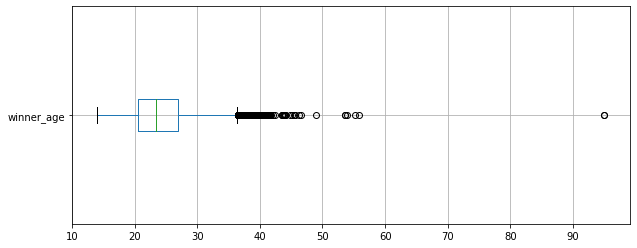

In [14]:
# let's try to find outliers in age with boxplot visualization
df_tennis.boxplot(vert=False, column=['winner_age'], return_type='axes',figsize=(10, 4))

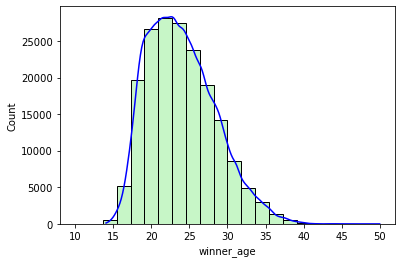

In [17]:
sns.histplot(data=df_tennis['winner_age'], bins="sturges", binrange=(10,50), color="lightgreen", kde=True, kde_kws={'clip':(10,50)}).lines[0].set_color('blue')

In [ ]:
#loser age

In [18]:
print(str(df_tennis['loser_age'].max()) + " -> " + ConvertAge(df_tennis['loser_age'].max()))
print(str(df_tennis['loser_age'].min()) + " -> " + ConvertAge(df_tennis['loser_age'].min()))

74.4859685147 -> 74 years, 5 months, 22 days
14.006844627 -> 14 years, 0 months, 2 days


In [19]:
# prints a table sorted by winner age, with tournament, winner name and tournament date
df_tennis_tmp = df_tennis.copy() # avoid overwrite original dataset
df_tennis_tmp['loser_age'] = df_tennis_tmp['loser_age'].dropna().apply(lambda x: ConvertAge(x))
df_tennis_tmp['tourney_date'] = pd.to_datetime(df_tennis_tmp['tourney_date'], format='%Y%m%d')
df_tennis_tmp[['tourney_name', 'tourney_date', 'loser_name', 'loser_age']].dropna().sort_values(by='loser_age')

,tourney_name,tourney_date,loser_name,loser_age
128331,Sandelfjord $15K,2018-07-23,Katja Wiersholm,"14 years, 0 months, 14 days"
150371,W15 Cancun,2019-04-15,Isabella Kruger,"14 years, 0 months, 15 days"
122036,Manacor Mallorca $15K,2018-02-05,Gloria Alogo Piqueras,"14 years, 0 months, 16 days"
39655,Tampere $10K,2016-07-18,Emilia Salo,"14 years, 0 months, 2 days"
18856,Heraklion $15K,2017-04-03,Sapfo Sakellaridi,"14 years, 0 months, 2 days"
...,...,...,...,...
137039,W60 Saguenay,2019-10-21,Sylvia Schenck,"55 years, 8 months, 19 days"
162479,W15 Guatemala,2019-11-04,Sylvia Schenck,"55 years, 9 months, 2 days"
176953,W25 Evansville IN,2021-07-12,Sylvia Schenck,"57 years, 5 months, 11 days"
176662,W25 Naples FL,2021-05-03,Gail Falkenberg,"74 years, 3 months, 14 days"


<AxesSubplot:>

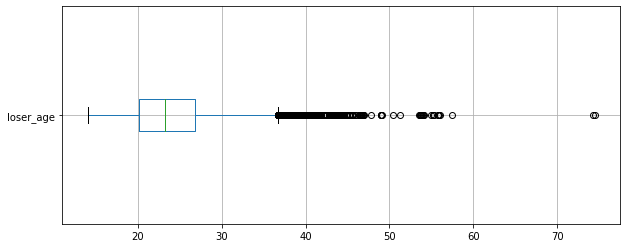

In [20]:
df_tennis.boxplot(vert=False, column=['loser_age'], return_type='axes',figsize=(10, 4))

<AxesSubplot:xlabel='loser_age', ylabel='Density'>

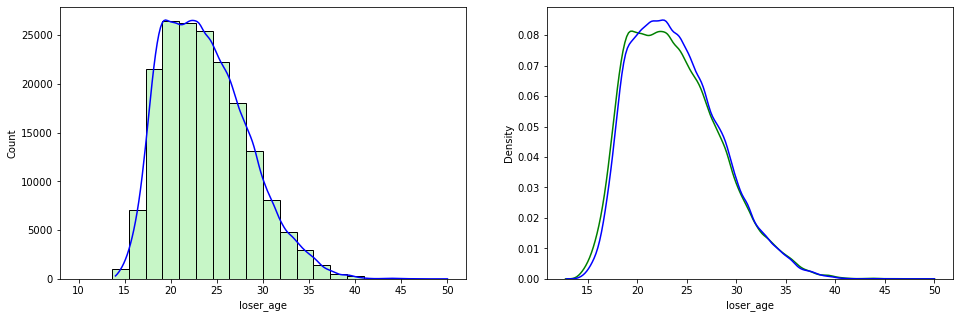

In [41]:
#df_tennis['winner_age'].hist(bins=50, grid=False, range=(10, 50))
#df_tennis['winner_age'].plot(kind='kde', xlim=[10,50])

fig = plt.figure(figsize=(16, 5)) 
fig_dims = (1, 2)

plt.subplot2grid(fig_dims, (0, 0))
sns.histplot(data=df_tennis['loser_age'], bins="sturges", binrange=(10,50), color="lightgreen", kde=True, kde_kws={'clip':(10,50)}).lines[0].set_color('blue')

plt.subplot2grid(fig_dims, (0, 1))
sns.kdeplot(data=df_tennis['loser_age'], color="green", clip=(10,50))
sns.kdeplot(data=df_tennis['winner_age'], color="blue", clip=(10,50))

#### w_df

In [ ]:
def ConvertTime(time):
    hours = int(time)
    minutes = (time*60) % 60
    seconds = (time*3600) % 60
    return ("%dH:%02dm:%02ds" % (hours, minutes, seconds))

#### minutes

In [ ]:
df_tennis.loc[df_tennis['minutes'] <= 0, 'minutes'].count()

In [ ]:
print(str(df_tennis['minutes'].mean()) + " converted-> " + ConvertTime(df_tennis['minutes'].mean()))

In [ ]:
print(str(df_tennis['minutes'].max()) + " converted-> " + ConvertTime(df_tennis['minutes'].max()))

In [ ]:
print(str(df_tennis['minutes'].min()) + " converted-> " + ConvertTime(df_tennis['minutes'].min()))

In [ ]:
# let's try to find outliers in minutes with scatter visualization
df_tennis.boxplot(vert=False, column=['minutes'], return_type='axes',figsize=(10, 4))

In [ ]:
sns.histplot(data=df_tennis['minutes'], bins="doane", binrange=(0,300), color="lightgreen", kde=True, kde_kws={'clip':(10,300)}).lines[0].set_color('blue')

There are 128 entry with a match duration equal to 0, a tennis match duration is on average 40 minutes our mean is 97.67.

In [ ]:
# we check that matches with 0 minutes are matches with BYE and WOLKOVER (in this case the match is not played)
def IsMatchWithZeroIncorrect(match):
    tmp = str(match)
    sets = tmp.split()    
    if len(sets)==1 and Walkover(sets[0]):
        return False
    if len(sets)==1 and Bye(sets[0]):
        return False
    return True

df_tennis_min_filtered = df_tennis[df_tennis['minutes']<= 0]
df_tennis_min_checked = df_tennis_min_filtered.apply(lambda x: IsMatchWithZeroIncorrect(x['score']), axis=1)
df_tennis_min_zero_res = df_tennis_min_filtered[df_tennis_min_checked]
df_tennis_min_zero_res[['tourney_id', 'score', 'minutes']]

0 could be considered as a default value

#### w_ace, w_df and w_svpt

In [ ]:
# TODO: W_ace: winner's number of aces; W_df: winner's number of doubles faults; W_svpt: winner's number of serve points
negative_w_ace = df_tennis.loc[df_tennis['w_ace'] < 0].shape[0]
print(negative_w_ace)

In [ ]:
#check if there are more ace than service performed
df_tennis.loc[df_tennis['w_svpt'] < df_tennis['w_ace']].shape[0]

In [ ]:
df_tennis.plot.scatter('w_svpt', 'w_ace')
plt.show()

In [ ]:
#W_df: winner's number of doubles faults
negative_w_df = df_tennis.loc[df_tennis['w_df'] < 0].shape[0]
print(negative_w_df)

In [ ]:
df_tennis.plot.scatter('w_svpt', 'w_df')
plt.show()

In [ ]:
#check if there are more double faults than service performed
df_tennis.loc[df_tennis['w_svpt'] < df_tennis['w_df']].shape[0]

In [ ]:
#W_svpt: winner's number of serve points
negative_w_ace = df_tennis.loc[df_tennis['w_svpt'] < 0].shape[0]
print(negative_w_ace)

In [ ]:
#check for outliers for w_svpt
df_tennis.boxplot(vert=False, column=['w_svpt'], return_type='axes',figsize=(10, 3))
plt.show()

There are outiliers in the service point, values that goes over twenty-five hundred.
*It can be theoretically possible.*

In [ ]:
df_tennis.loc[df_tennis['w_svpt'] >250].shape[0]

#### l_ace, l_df and l_svpt

In [ ]:
# TODO: l_ace: loser's number of aces; l_df: loser's number of doubles faults; l_svpt: loser's number of serve points

#### w_1stIn

In [ ]:
# TODO: W_1stln: winner’s number of first serves made
#check to find negative values
df_tennis.loc[df_tennis['w_1stIn'] < 0].shape[0]

#### l_1stIn

In [ ]:
# TODO: loser’s number of first serves made

#### w_1stWon and w_2ndWon

In [ ]:
#check to find negative values
df_tennis.loc[df_tennis['w_1stWon'] < 0].shape[0]

In [ ]:
#check if there are more w_1stWon than fist service performed
df_tennis.loc[df_tennis['w_1stIn'] < df_tennis['w_1stWon']].shape[0]

In [ ]:
#check to find negative values
df_tennis.loc[df_tennis['w_2ndWon'] < 0].shape[0]

#### l_1stWon and l_2ndWon


In [ ]:
# TODO: l_1stWon: loser’s number of first-serve points won; l_2stwon: loser’s number of second-serve points won

#### w_SvGms,  w_bpSaved and w_bpFaced
service game means the games that the player wins without the oppent scoring 

In [ ]:
# TODO: W_SvGms: winner’s number of serve games; W_bdSaved: winner's number of breakpoints saved; W_bdFaced: winner's number of breakpoints faced

#### l_SvGms,  l_bpSaved and l_bpFaced

In [ ]:
# TODO: l_SvGms: loser’s number of serve games; l_bdSaved: loser's number of breakpoints saved; l_bdFaced: winner's number of breakpoints faced

#### Winner_rank

In [ ]:
#TO DO: fare una stima del massimo per maschi e femmine per capire all'incirca quanti sono i giocatori maschili/femminili professionisti

In [108]:
df_tennis['winner_rank']

0           9.0
1          16.0
2           9.0
3         239.0
4          16.0
          ...  
186123      NaN
186124    255.0
186125      NaN
186126    176.0
186127      NaN
Name: winner_rank, Length: 186128, dtype: float64

In [96]:
df_tennis['winner_rank'].max()

2220.0

In [100]:
 df_tennis['winner_rank'].min() >= 1 #there cannot be rank smaller than 1

True

In [102]:
 df_tennis['winner_rank'].min()

1.0

#### Winner_rank_points

In [89]:
#TO DO: GRAFICI SEPARATI IN BASE ALLE CLASSIFICHE MASCHILI E FEMMINILI SEPARATE

In [34]:
df_tennis['winner_rank_points'].max()<21750 #21750 is the maximum a player can reach

True

In [30]:
df_tennis['winner_rank_points'].max()

16950.0

In [32]:
df_tennis['winner_rank_points'].min()

1.0

In [93]:
df_tennis[df_tennis['winner_rank_points'] == df_tennis['winner_rank_points'].min()].shape[0] 

209

<AxesSubplot:xlabel='winner_rank_points', ylabel='Count'>

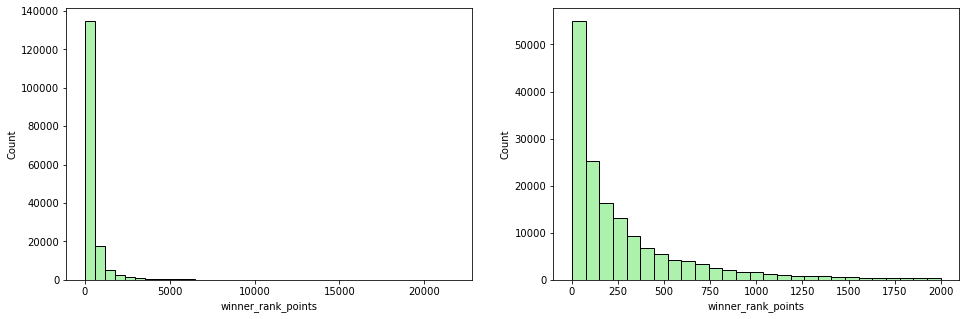

In [65]:
fig = plt.figure(figsize=(16, 5)) 
fig_dims = (1, 2)

plt.subplot2grid(fig_dims, (0, 0))
sns.histplot(data=df_tennis['winner_rank_points'], bins="doane", binrange=(0,21750), color="lightgreen")

plt.subplot2grid(fig_dims, (0, 1))
sns.histplot(data=df_tennis['winner_rank_points'], bins="doane", binrange=(0,2000), color="lightgreen")

## Missing values: default value

In [ ]:
# TODO:

## Correlation

In [ ]:
df_numeric = df_tennis[df_tennis.select_dtypes(include=['float64']).columns]

In [ ]:
#start with a filter on the correlation of |0.90|

In [ ]:
df_numeric.corr()

inserire ragionamento sulla correlation

## Statistics/distributions

In [ ]:
#some statistics
#df_tennis.describe()

# Idee Data Preparation

In [ ]:
#TO DO: MODIFICARE "A MANO" TUTTI QUELLI SENZA COGNOME MA CON LA VIRGOLA NEL NOME

In [ ]:
#TO DO: hands- sostituire gli unknown con le hands usate dallo stesso giocatore per altri match

In [ ]:
#TO DO? UN'ANALISI CHE POTREMMO FARE è DI VEDERE LA PERCENTUALE DI MATCH DOVE IL GIOCATORE SI è RITIRATO O è STATO 
#SQUALIFICATO RISPETTO AL NUMERO DI PARTITE SOSTENUTE TOTALI